<a href="https://colab.research.google.com/github/abdulrahmanmoamen/ITI-project/blob/main/Image_Forgery_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Unzip the dataset archive from Google Drive into the local working directory
!unzip "/content/drive/MyDrive/archive (3).zip" -d /content/mini_forgery_dataset


Archive:  /content/drive/MyDrive/archive (3).zip
  inflating: /content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_auth/4cam_auth/canong3_02_sub_01.tif  
  inflating: /content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_auth/4cam_auth/canong3_02_sub_02.tif  
  inflating: /content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_auth/4cam_auth/canong3_02_sub_03.tif  
  inflating: /content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_auth/4cam_auth/canong3_02_sub_04.tif  
  inflating: /content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_auth/4cam_auth/canong3_02_sub_05.tif  
  inflating: /content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_auth/4cam_auth/canong3_02_sub_06.tif  
  inflating: /content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_auth/4cam_auth/canong3_02_sub_07.tif  
  inflating: 

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
# Define base paths for the dataset, including images and corresponding masks
base_path = "/content/mini_forgery_dataset"
img_dir = os.path.join(base_path, "images")
mask_dir = os.path.join(base_path, "masks")

In [4]:
# Define valid image extensions and helper function to check if a file is an image

valid_ext = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

def is_image(filename):
    return os.path.splitext(filename)[1].lower() in valid_ext
# Initialize lists to store images (X) and corresponding masks (y)

X = []
y = []

In [5]:
# Define paths for authentic (unaltered) images and spliced (forged) images
# from the Columbia Uncompressed Image Splicing Detection dataset
auth_dir = "/content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_auth/4cam_auth"
spliced_dir = "/content/mini_forgery_dataset/Columbia Uncompressed Image Splicing Detection/4cam_splc/4cam_splc"


In [6]:
# Load and preprocess authentic (unaltered) images:
# - Resize to 128x128
# - Normalize pixel values to [0, 1]
# - Label them as 0 (authentic)
for filename in tqdm(os.listdir(auth_dir)):
    path = os.path.join(auth_dir, filename)
    img = cv2.imread(path)
    if img is None:
        continue
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    X.append(img)
    y.append(0)

100%|██████████| 183/183 [00:01<00:00, 128.68it/s]


In [7]:
# Load and preprocess spliced (forged) images:
# - Resize to 128x128
# - Normalize pixel values to [0, 1]
# - Label them as 1 (spliced)
for filename in tqdm(os.listdir(spliced_dir)):
    path = os.path.join(spliced_dir, filename)
    img = cv2.imread(path)
    if img is None:
        continue
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    X.append(img)
    y.append(1)

100%|██████████| 180/180 [00:00<00:00, 266.04it/s]


In [8]:
# Convert image and label lists to NumPy arrays for model training

X = np.array(X)
y = np.array(y)


In [9]:
print("عدد الصور:", X.shape)
print("عدد التصنيفات:", y.shape)

عدد الصور: (363, 128, 128, 3)
عدد التصنيفات: (363,)


In [10]:

np.save("/content/drive/MyDrive/X_data.npy", X)
np.save("/content/drive/MyDrive/y_data.npy", y)


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
# Split the dataset into training and testing sets (80% train, 20% test) with a fixed random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Convert labels to one-hot encoded format for categorical classification
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [14]:
# Build a CNN model with 3 convolutional layers followed by dense layers
# Designed for binary classification with softmax output
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the model with Adam optimizer and categorical crossentropy loss,
# then train it for 15 epochs with batch size of 32, using validation data for monitoring
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, epochs=15, batch_size=32, validation_data=(X_test, y_test_cat))


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5241 - loss: 0.7536 - val_accuracy: 0.5479 - val_loss: 0.6893
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 800ms/step - accuracy: 0.5414 - loss: 0.6940 - val_accuracy: 0.4384 - val_loss: 0.7157
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 994ms/step - accuracy: 0.5418 - loss: 0.6975 - val_accuracy: 0.4384 - val_loss: 0.6965
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5563 - loss: 0.6576 - val_accuracy: 0.6986 - val_loss: 0.6098
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 787ms/step - accuracy: 0.7301 - loss: 0.5868 - val_accuracy: 0.7260 - val_loss: 0.6191
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 869ms/step - accuracy: 0.7082 - loss: 0.6024 - val_accuracy: 0.7534 - val_loss: 0.5753
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 991ms/step - accuracy: 0.7668 - loss: 0.5407 - val_accuracy: 0.7534 - val_loss: 0.5480
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 894ms/step - accuracy: 0.7738 - loss: 0.4999 - val_accuracy: 0.6

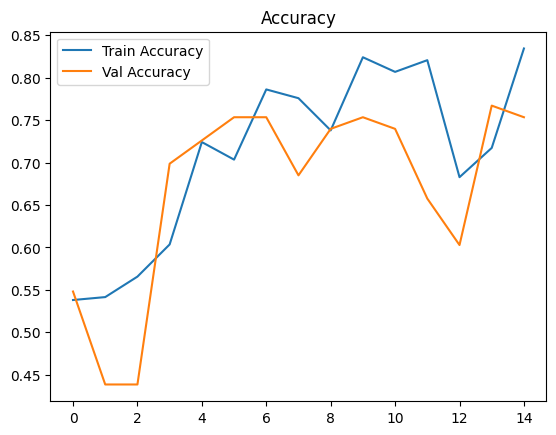

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

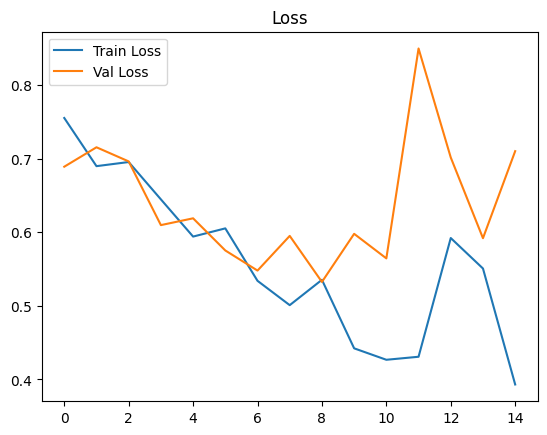

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [18]:
model.save("/content/drive/MyDrive/image_forgery_model.h5")

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


In [21]:
cm = confusion_matrix(y_test, y_pred)


In [22]:
report = classification_report(y_test, y_pred, target_names=['Authentic', 'Spliced'])
print(report)


              precision    recall  f1-score   support

   Authentic       0.79      0.76      0.78        41
     Spliced       0.71      0.75      0.73        32

    accuracy                           0.75        73
   macro avg       0.75      0.75      0.75        73
weighted avg       0.76      0.75      0.75        73



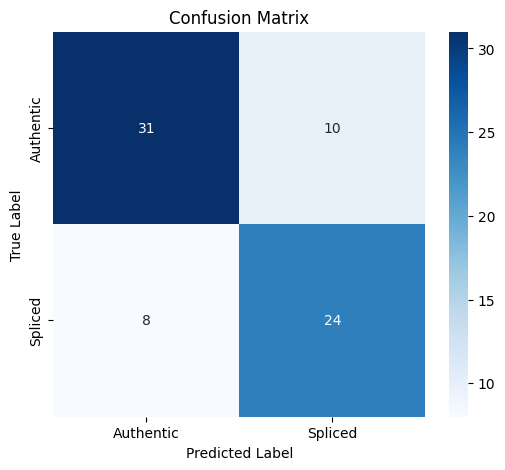

In [23]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Authentic', 'Spliced'], yticklabels=['Authentic', 'Spliced'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [26]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [27]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32)
val_generator = test_datagen.flow(X_test, y_test_cat, batch_size=32)


In [28]:
base_model = MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 828ms/step - accuracy: 0.4127 - loss: 1.0241 - val_accuracy: 0.5479 - val_loss: 0.8365
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.4953 - loss: 0.9754 - val_accuracy: 0.6027 - val_loss: 0.8175
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 542ms/step - accuracy: 0.6121 - loss: 0.8619 - val_accuracy: 0.6438 - val_loss: 0.7757
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - accuracy: 0.5250 - loss: 0.8847 - val_accuracy: 0.6438 - val_loss: 0.7532
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 699ms/step - accuracy: 0.6119 - loss: 0.7447 - val_accuracy: 0.6849 - val_loss: 0.7001
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 442ms/step - accuracy: 0.6048 - loss: 0.7500 - val_accuracy: 0.6575 - val_loss: 0.6672
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step - accuracy: 0.6383 - loss: 0.6741 - val_accuracy: 0.6712 - val_loss: 0.6700
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 626ms/step - accuracy: 0.6146 - loss: 0.7174 - val_accuracy: 0

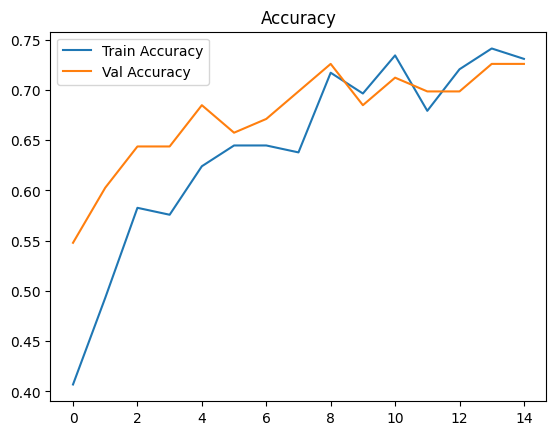

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

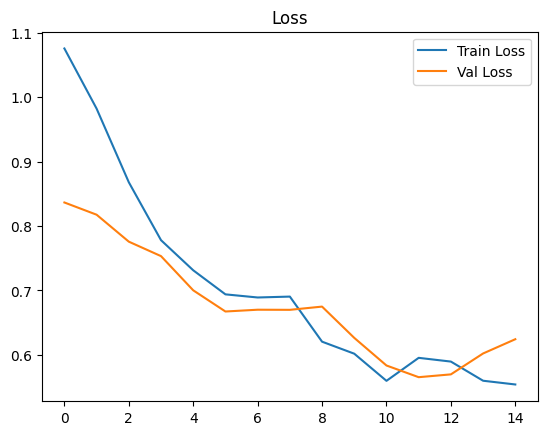

In [33]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step


In [36]:
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Authentic", "Spliced"]))


📊 Classification Report:

              precision    recall  f1-score   support

   Authentic       0.92      0.56      0.70        41
     Spliced       0.62      0.94      0.75        32

    accuracy                           0.73        73
   macro avg       0.77      0.75      0.72        73
weighted avg       0.79      0.73      0.72        73



In [37]:
model.save("/content/drive/MyDrive/final_mobilenetv2_model.h5")


In [38]:
img = cv2.imread("/content/drive/MyDrive/1 folder/images/14.jpeg")
img = cv2.resize(img, (128, 128)) / 255.0
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
print("Predicted class:", np.argmax(prediction))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted class: 1


In [39]:
img = cv2.imread("/content/drive/MyDrive/1 folder/images/2.jpeg")
img = cv2.resize(img, (128, 128)) / 255.0
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
print("Predicted class:", np.argmax(prediction))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted class: 1
